In [11]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import collections, colors, cm

In [12]:
# inputs:
#    p - polynomial degree corresponding to knotvector U
#    U - knotvector
#    u - parametric coordinate (must be inside the domain defined by U to be valid)
# outputs:
#    span - index such that u is inside the interval [U[span], U[span+1])
def find_span(p, U, u):
    n = len(U) - p - 2
    if u == U[n+1]:
        return n
    low = p
    high = n + 1
    mid = (low + high) // 2
    while u < U[mid] or u >= U[mid+1]:
        if u < U[mid]:
            high = mid
        else:
            low = mid
        mid = (low + high) // 2
    span = mid
    return span

# inputs:
#    p - polynomial degree corresponding to knotvector U
#    U - knotvector
# outputs:
#    n_spans - number of bezier spans in domain of knotvector U
def find_number_of_spans(p, U):
    n_spans = 0
    i = p
    n = len(U) - p - 1
    while i < n:
        if U[i] != U[i+1]:
            n_spans += 1
        i += 1
    return n_spans

# inputs:
#    n - integer
#    k - integer
# outputs:
#    nCk - returns binomial coefficient "n choose k"
def binomial_coef(n, k):
    if k == 0:
        return 1
    if n == 0 or k > n:
        return 0
    r = 1
    if k > (n - k):
        k = n - k
    for d in range(1, k+1):
        r *= n
        r /= d
        n = n - 1
    return r

# inputs:
#    p - bspline degree
#    U - bspline knotvector
#    P - bspline control points
#    t - number of times to elevate bspline degree
# outputs:
#    V - degree elevated bspline knotvector
#    Q - degree elevated bspline control points
def elevate_degree_bspline_curve(p, U, P, t):
    if t < 1:
        return U.copy(), P.copy()

    n = len(P)-1
    m = n + p + 1
    
    bezalfs = np.zeros([p + t + 1, p + 1])
    
    dim = P.shape[1]
    bpts = np.zeros([p+1,dim])
    ebpts = np.zeros([p + t + 1,dim])
    Nextbpts = np.zeros([p - 1,dim])
    alphas = [0.0] * (p - 1)

    ph = p + t
    ph2 = ph // 2

    bezalfs[0,0] = 1.0;
    bezalfs[ph,p] = 1.0;

    for i in range(1, ph2+1):
        inv = 1.0 / binomial_coef(ph, i)
        mpi = min(p, i)
        for j in range(max(0,i-t), mpi+1):
            bezalfs[i,j] = inv * binomial_coef(p, j) * binomial_coef(t, i - j)
    for i in range(ph2+1, ph):
        mpi = min(p, i)
        for j in range(max(0,i-t), mpi+1):
            bezalfs[i,j] = bezalfs[ph-i, p-j]

    n_spans = find_number_of_spans(p, U)
            
    Q = np.zeros([n+1+t*n_spans, dim])
    V = np.zeros([m+1+t*(n_spans+1)])

    mh = ph
    kind = ph+1
    r = -1
    a = p
    b = p+1
    cind = 1
    ua = U[0]
    
    Q[0] = P[0]
    
    for i in range(0,ph):
        V[i] = ua
    for i in range(0,p+1):
        bpts[i] = P[i]
        
    while b < m:
        i = b
        while b < m and U[b] == U[b + 1]:
            b += 1
        mul = b - i + 1
        mh = mh + mul + t
        ub = U[b]
        oldr = r
        r = p - mul
        lbz = (oldr + 2) // 2 if oldr > 0 else 1
        rbz = ph - (r + 1) // 2 if r > 0 else ph

        if r > 0:
            numer = ub - ua;
            alfs = [0.0] * (p + 1)
            for k in range(p, mul, -1):
                alfs[k - mul - 1] = numer / (U[a + k] - ua)
            
            for j in range(1,r+1):
                save = r - j
                s = mul + j
                for k in range(p,s-1,-1):
                    bpts[k] = alfs[k - s] * bpts[k] + (1.0 - alfs[k - s]) * bpts[k - 1]
                Nextbpts[save] = bpts[p]
 
        for i in range(lbz,ph+1):
            ebpts[i,:] = 0.0
            mpi = np.min([p,i])
            for j in range(max(i-t,0), mpi+1):
                ebpts[i] += bezalfs[i,j] * bpts[j]
 
        if oldr > 1:
            first = kind - 2
            last = kind
            den = ub - ua
            bet = (ub - V[kind - 1]) / den
            for tr in range(1,oldr):
                i = first
                j = last
                kj = j - kind + 1
                while j - i > tr:
                    if i < cind:
                        alf = (ub - V[i]) / (ua - V[i])
                        Q[i+1,:] = alf * Q[i+1] + (1.0 - alf) * Q[i]
                    if j >= lbz:
                        if j - tr <= kind - ph + oldr:
                            gam = (ub - V[j - tr]) / den
                            ebpts[kj] = gam * ebpts[kj] + (1.0 - gam) * ebpts[kj + 1]
                        else:
                            ebpts[kj] = bet * ebpts[kj] + (1.0 - bet) * ebpts[kj + 1]

                    i += 1
                    j -= 1
                    kj -= 1
                first -= 1
                last += 1
 
        if a != p:
            for i in range(ph-oldr):
                V[kind] = ua
                kind += 1
 
        for j in range(lbz,rbz+1):
            Q[cind] = ebpts[j]
            cind += 1
 
        if b < m:
            for j in range(r):
                bpts[j] = Nextbpts[j]
            for j in range(r,p+1):
                bpts[j] = P[b - p + j]
            a = b
            b += 1
            ua = ub
        else:
            for i in range(ph+1):
                V[kind + i] = ub
    return V, Q

# inputs:
#    p - bspline degree
#    U - bspline knotvector
#    P - bspline control points
#    X - array of knots to insert (must be valid)
# outputs:
#    V - refined bspline knotvector
#    Q - refined bspline control points
def insert_knots_bspline_curve(p, U, P, X):
    r = len(X) - 1
    if r < 0:
        return U.copy(), P.copy()
    n = len(P) - 1
    m = n + p + 1
    a = find_span(p, U, X[0])
    b = find_span(p, U, X[r]) + 1
    dim = P.shape[1]
    V = np.zeros([m + r + 2])
    Q = np.zeros([n + r + 2, dim])
    for j in range(a-p+1):
        Q[j] = P[j]
    for j in range(b-1, n+1):
        Q[j+r+1] = P[j]
    for j in range(a+1):
        V[j] = U[j]
    for j in range(b+p, m+1):
        V[j+r+1] = U[j]
    i = b + p - 1
    k = b + p + r
    for j in range(r, -1, -1):
        while X[j] <= U[i] and i > a:
            Q[k-p-1] = P[i-p-1]
            V[k] = U[i]
            k -= 1
            i -= 1
        Q[k-p-1] = Q[k-p]
        for l in range(1, p+1):
            ind = k - p + l
            alfa = V[k+l] - X[j]
            if abs(alfa) == 0.0:
                Q[ind-1] = Q[ind]
            else:
                alfa = alfa / (V[k+l]-U[i-p+l])
                Q[ind-1] = alfa * Q[ind-1] + (1.0 - alfa) * Q[ind]
        V[k] = X[j]
        k -= 1
    return V, Q

# inputs:
#    direction - = 0 to insert knots in X along u0 coordinate direction, or
#                = 1 to insert knots in X along u1 coordinate direction
#    p - bspline degree in u{direction} coordinate direction
#    U - bspline knotvector in u{direction} coordinate direction
#    P - vector of bspline control points ordered such that 
#        the (i,j)'th control point is given by P[i + j * n0] where n0
#        is the number of control points in the u0 coordinate direction
#    X - array of knots to insert (must be valid)
# outputs:
#    V - refined bspline knotvector in u{direction} coordinate
#    Q - refined bspline control points
def insert_knots_bspline_surface(direction, p, U, P, X):
    ncps = len(P)
    ncps_dir0 = len(U) - p - 1
    ncps_dir1 = ncps // ncps_dir0
    ncps_new = ncps_dir0 + len(X)
    Q = np.zeros([ncps_new * ncps_dir1, P.shape[1]])
    for i in range(ncps_dir1):
        if direction == 0:
            inds = np.arange(ncps_dir0) + i * ncps_dir0
            inds_new = np.arange(ncps_new) + i * ncps_new
        else:
            inds = i + np.arange(ncps_dir0) * ncps_dir1
            inds_new = i + np.arange(ncps_new) * ncps_dir1
        Phat = P[inds]
        V, Q[inds_new] = insert_knots_bspline_curve(p, U, Phat, X)
    return V, Q

# inputs:
#    direction - = 0 to degree elevate in u0 coordinate direction, or
#                = 1 to degree elevate in u1 coordinate direction
#    p - bspline degree in u{direction} coordinate direction
#    U - bspline knotvector in u{direction} coordinate direction
#    P - vector of bspline control points ordered such that 
#        the (i,j)'th control point is given by P[i + j * n0] where n0
#        is the number of control points in the u0 coordinate direction
#    t - number of times to elevate bspline degree
# outputs:
#    V - refined bspline knotvector in u{direction} coordinate
#    Q - refined bspline control points
def elevate_degree_bspline_surface(direction, p, U, P, t):
    ncps = len(P)
    ncps_dir0 = len(U) - p - 1
    ncps_dir1 = ncps // ncps_dir0
    n_spans = find_number_of_spans(p, U)
    ncps_new = ncps_dir0 + t * n_spans
    Q = np.zeros([ncps_new * ncps_dir1, P.shape[1]])
    for i in range(ncps_dir1):
        if direction == 0:
            inds = np.arange(ncps_dir0) + i * ncps_dir0
            inds_new = np.arange(ncps_new) + i * ncps_new
        else:
            inds = i + np.arange(ncps_dir0) * ncps_dir1
            inds_new = i + np.arange(ncps_new) * ncps_dir1
        Phat = P[inds]
        V, Q[inds_new] = elevate_degree_bspline_curve(p, U, Phat, t)
    return V, Q

# inputs:
#    ri - inner radius of quarter circle
#    ro - outer radius of quarter circle
#    p0 - bspline degree in u0 coordinate direction (must be at least 2)
#    p1 - bspline degree in u1 coordinate direction (must be at least 2)
#    N0 - Number of elems in u0 coordinate direction
#    N1 - Number of elems in u1 coordinate direction
# outputs:
#    U1 - bspline knotvector in u1 coordinate direction
#    U2 - bspline knotvector in u2 coordinate direction
#    P - vector of bspline control points ordered such that 
#        the (i,j)'th control point is given by P[i + j * n0] where n0
#        is the number of control points in the u1 coordinate direction
#    w - vector of control point weights such that 
#        the (i,j)'th control point weight is given by w[i + j * n0] where n0
#        is the number of control points in the u1 coordinate direction
def build_nurbs_quarter_circle(ri, ro, p0, p1, N0, N1):
    assert p0 >= 2
    assert p1 >= 2
    assert ro > ri
    assert N0 > 0
    assert N1 > 0
    
    # start out with simple bezier template
    P = np.array([
        [0, ri],    [ri, ri],    [ri, 0],
        [0, ro],    [ro, ro],    [ro, 0],
    ])
    w = np.array([
        1,    1/np.sqrt(2),   1,
        1,    1/np.sqrt(2),   1,
    ])
    Pw = np.append(P * w[:, np.newaxis], np.expand_dims(w, axis=1), axis=1)
    U0 = np.array([0,0,0,1,1,1])
    U1 = np.array([0,0,1,1])
    
    # degree elevate
    U0, Pw = elevate_degree_bspline_surface(0, 2, U0, Pw, p0-2)
    U1, Pw = elevate_degree_bspline_surface(1, 1, U1, Pw, p1-1)
    
    # knot insertion
    X0 = np.linspace(U0[p0], U0[len(U0)-p0], N0+1)[1:-1]
    X1 = np.linspace(U1[p1], U1[len(U1)-p1], N1+1)[1:-1]

    # test nonuniform refinement in radial direction
    # just using random knots - so may need to try a couple times to get reasonably spaced knots
#     X0 = np.sort(np.random.uniform(low=U0[p0], high=U0[len(U0)-p0], size=N0-1))
#     X1 = np.sort(np.random.uniform(low=U1[p1], high=U1[len(U1)-p1], size=N1-1))

    U0, Pw = insert_knots_bspline_surface(0, p0, U0, Pw, X0)
    U1, Pw = insert_knots_bspline_surface(1, p1, U1, Pw, X1)

    w = Pw[:, 2]
    P = Pw[:, 0:2] / w[:, np.newaxis]
    return U0, U1, P, w

# This function helps to construct the ID array for this particular problem
# inputs:
#    p0 - polynomial degree corresponding to knotvector U0
#    p1 - polynomial degree corresponding to knotvector U1
#    U0 - knotvector in u0 coordinate direction
#    U1 - knotvector in u1 coordinate direction
#    N0 - number of elements in xi0 coordinate direction
#    N1 - number of elements in xi1 coordinate direction
# outputs:
#    constrained_dofs - array of global dof indices that are constrained (homogeneous dirichlet)
#    neumann edges - array where neumann_edges[i] is the j'th edge of the i'th element
#                    Note: this uses convention where j = 0 (bottom), = 1 (top), = 2 (left), or = 3 (right)
def build_boundary_condition_array(p0, p1, U0, U1, N0, N1):
    n0 = len(U0) - p0 - 1
    n1 = len(U1) - p1 - 1
    constrained_dofs = np.concatenate([[[(n0-1) + n0 * j, 1] for j in range(n1)], [[n0 * j, 0] for j in range(n1)]]).astype(int)
    neumann_edges = np.array([[i, 0] for i in range(N0)], dtype=int)
    return constrained_dofs, neumann_edges

# This function helps to construct the ID array for this particular problem
# inputs:
#    p0 - polynomial degree corresponding to knotvector U0
#    p1 - polynomial degree corresponding to knotvector U1
#    U0 - knotvector in u0 coordinate direction
#    U1 - knotvector in u1 coordinate direction
#    constraints - array of global dof indices to apply homogeneous dirichlet constraint
# outputs:
#    ID - the ID array where ID[i,j] returns the global equation number or -1 if constrained
def build_ID_array(p0, p1, U0, U1, constraints):
    n0 = len(U0) - p0 - 1
    n1 = len(U1) - p1 - 1
    ncps = n0 * n1
    ID = np.zeros([ncps, 2], dtype=int)
    for constraint in constraints:
        ID[constraint[0], constraint[1]] = -1
    eq = 0
    for i in range(ncps):
        for j in range(2):
            if ID[i, j] == -1:
                continue
            ID[i, j] = eq 
            eq += 1
    return ID

# inputs:
#    p - polynomial degree corresponding to knotvector U
#    U - knotvector
# outputs:
#    C - array of (p+1) X (p+1) element extraction operators
def compute_element_bezier_extraction_operators(p, U):
    m = len(U)
    a = p + 1
    b = a + 1
    e = 0
    C = [np.eye(p+1)]
    while b < m:
        Ce_next = np.eye(p+1)
        i = b
        while b < m and U[b] == U[b-1]:
            b += 1
        mult = b - i + 1
        if mult < p:
            numer = U[b-1] - U[a-1]
            alphas = np.zeros([p+1])
            for j in range(p, mult, -1):
                alphas[j-mult-1] = numer / (U[a+j-1] - U[a-1])
            r = p - mult
            for j in range(1,r+1):
                save = r - j
                s = mult + j
                for k in range(p, s-1, -1):
                    alpha = alphas[k-s]
                    C[e][:,k] = alpha * C[e][:,k] + (1.0 - alpha) * C[e][:,k-1]
                if b < m:
                    Ce_next[save:save+j+1, save] = C[e][p-j:p+1, p]
            e += 1
            if b < m:
                a = b
                b += 1
                C.append(Ce_next)
    return C

# inputs:
#    p0 - polynomial degree corresponding to knotvector U0
#    p1 - polynomial degree corresponding to knotvector U1
#    U0 - knotvector in u0 coordinate direction
#    U1 - knotvector in u1 coordinate direction
# outputs:
#    Ce - array of (p0+1)*(p1+1) X (p0+1)*(p1+1) element extraction operators
def compute_element_bezier_extraction_operators_2d(p0, p1, U0, U1):
    C0 = compute_element_bezier_extraction_operators(p0, U0)
    C1 = compute_element_bezier_extraction_operators(p1, U1)
    return [np.kron(Ce1, Ce0) for Ce1 in C1 for Ce0 in C0]

# inputs:
#    p - polynomial degree
#    xi - parametric coordinate
# outputs:
#    B - vector of length (p+1) containing the values of the each basis function evaluated at xi
#        where the j'th element corresponds to the j'th bernstein polynomial
#    dBdxi - vector of length (p+1) containing the derivatives of the each basis function evaluated at xi
#        where the j'th element corresponds to the derivative of the j'th bernstein polynomial
def bernstein_basis_function_values_and_derivatives(p, xi):
    B = np.zeros([p+1])
    dBdxi = np.zeros([p+1])
    J = 0.5**p
    for i in range(p+1):
        bin_coef = binomial_coef(p, i)
        B[i] = bin_coef * J * (1+xi)**i * (1-xi)**(p-i)
        dBdxi0 = 0 if i == 0 else i * (xi+1)**(i-1) * (1-xi)**(p-i)
        dBdxi1 = 0 if i == p else (p-i) * (xi+1)**i * (1-xi)**(p-i-1)
        dBdxi[i] = bin_coef * J * (dBdxi0 - dBdxi1)
    return B, dBdxi

# inputs:
#    p - polynomial degree
#    xi - parametric coordinate
# outputs:
#    B - vector of length (p+1) containing the values of the each basis function evaluated at xi
#        where the j'th element corresponds to the j'th bernstein polynomial
def bernstein_basis_function_values(p, xi):
    B = np.zeros([p+1])
    dBdxi = np.zeros([p+1])
    J = 0.5**p
    for i in range(p+1):
        bin_coef = binomial_coef(p, i)
        B[i] = bin_coef * J * (1+xi)**i * (1-xi)**(p-i)
    return B

# inputs:
#    p0 - polynomial degree in xi0 direction
#    p1 - polynomial degree in xi1 direction
#    xi0 - parametric coordinate in xi0 direction
#    xi1 - parametric coordinate xi1 direction
# outputs:
#    B - vector of length (p0+1)*(p1+1) containing the values of the each basis function evaluated at [xi0, xi1]
#        where the (i,j)'th basis function is given by B[i * (p1+1) + j]
#    dBdxi - matrix of shape [(p0+1)*(p1+1), 2] containing the derivatives of each basis function evaluated at [xi0, xi1]
#         where the kth derivative of the (i,j)'th basis function is given by dB[i * (p1+1) + j, k]
def bernstein_basis_function_values_and_derivatives_2d(p0, p1, xi0, xi1):
    B0, dBdxi0 =  bernstein_basis_function_values_and_derivatives(p0, xi0)
    B1, dBdxi1 =  bernstein_basis_function_values_and_derivatives(p1, xi1)
    shape = ((p0+1) * (p1+1),)
    B = np.reshape(B0[np.newaxis, :] * B1[:, np.newaxis], shape)
    dBdxi0 = np.reshape(dBdxi0[np.newaxis, :] * B1[:, np.newaxis], shape)
    dBdxi1 = np.reshape(B0[np.newaxis, :] * dBdxi1[:, np.newaxis], shape)
    dBdxi = np.stack([dBdxi0, dBdxi1], axis=-1)
    return B, dBdxi

# inputs:
#    p0 - polynomial degree in xi0 direction
#    p1 - polynomial degree in xi1 direction
#    xi0 - parametric coordinate in xi0 direction
#    xi1 - parametric coordinate xi1 direction
# outputs:
#    B - vector of length (p0+1)*(p1+1) containing the values of the each basis function evaluated at [xi0, xi1]
#        where the (i,j)'th basis function is given by B[i * (p1+1) + j]
def bernstein_basis_function_values_2d(p0, p1, xi0, xi1):
    B0 =  bernstein_basis_function_values(p0, xi0)
    B1 =  bernstein_basis_function_values(p1, xi1)
    shape = ((p0+1) * (p1+1),)
    B = np.reshape(B0[np.newaxis, :] * B1[:, np.newaxis], shape)
    return B

# inputs:
#    p0 - polynomial degree corresponding to knotvector U0
#    p1 - polynomial degree corresponding to knotvector U1
#    U0 - knotvector in u0 coordinate direction
#    U1 - knotvector in u1 coordinate direction
# outputs:
#    connectivity - matrix of dimension [number of elem, (p0+1) * (p1+1)] where
#                   the the (e,j)'th element is the global control point number
#                   corresponding the jth node of the e'th element
#    spans - matrix of dimension [number of elems, 2] where the (e,i)'th element
#            is the length of the parametric interval in the i'th coordinate direction
#            for the e'th element
def build_element_connectivity_and_span_arrays(p0, p1, U0, U1):
    m0 = len(U0) - 1
    m1 = len(U1) - 1
    n0 = m0 - p0
    a1 = p1
    b1 = a1 + 1
    connectivity = []
    spans = []
    while b1 < m1:
        ids1 = a1 - p1 + np.arange(p1+1)
        j = b1
        while b1 < m1 and U1[b1] == U1[b1 + 1]:
            b1 += 1
        mult1 = b1 - j + 1
        a0 = p0
        b0 = a0 + 1
        while b0 < m0:
            ids0 = a0 - p0 + np.arange(p0+1)
            ids = (ids0[np.newaxis,:] + n0 * ids1[:,np.newaxis]).flatten()
            elem_span = [[U0[a0], U0[b0]],[U1[a1], U1[b1]]]
            connectivity.append(ids)
            spans.append(elem_span)
            i = b0
            while b0 < m0 and U0[b0] == U0[b0 + 1]:
                b0 += 1
            mult0 = b0 - i + 1
            if b0 < m0:
                a0 = b0
                b0 += 1
        if b1 < m1:
            a1 = b1
            b1 += 1
    return np.array(connectivity), np.array(spans)

# inputs:
#    B - array of bernstein polynomial values
#    dBdxi - array of bernstein polynomial derivatives
#    Ce - element extraction operator
#    we - array of element control point weights
# outputs:
#    R - array of nurbs basis function values
#    dRdxi - array of nurbs basis function derivatives
def compute_element_basis_function_values_and_derivatives(B, dBdv, Ce, we):
    W = np.diag(we)
    w = we.dot(Ce.dot(B))
    R = W.dot(Ce).dot(B) / w
    dwdv = we.dot(Ce.dot(dBdv))
    dRdv = W.dot(Ce).dot((dBdv) / w - (B[:,np.newaxis] * dwdv[np.newaxis,:]) / w**2) 
    return R, dRdv

# inputs:
#    B - array of bernstein polynomial values
#    Ce - element extraction operator
#    we - array of element control point weights
# outputs:
#    R - array of nurbs basis function values
def compute_element_basis_function_values(B, Ce, we):
    W = np.diag(we)
    w = we.dot(Ce.dot(B))
    R = W.dot(Ce).dot(B) / w
    return R

# inputs:
#    R - array of nurbs basis function values
#    Pe - array of element control points
# outputs:
#    x - 2d nurbs point
def compute_nurbs_point(R, Pe):
    x = Pe.T.dot(R)
    return x

# inputs:
#    R - array of nurbs basis function values
#    Pe - array of element control points
# outputs:
#    dxdxi - 2X2 Jacobian matrix
def compute_nurbs_jacobian(dRdv, Pe):
    dxdv = Pe.T.dot(dRdv)
    return dxdv

# inputs:
#    E - Young's Modulus
#    nu - Poisson's Ratio
# outputs:
#    D - 3X3 Elasticity matrix
def compute_elasticity_matrix(E, nu):
    D = (E / (1-nu**2)) * np.array(
        [[1, nu, 0],
         [nu, 1, 0],
         [0, 0, (1-nu)/2]]
    )
    return D

# inputs:
#    dRdx - array of nurbs basis function derivatives
# outputs:
#    B - matrix of shape [3, 2 * number of element nodes]
def construct_strain_matrix(dRdx):
    B = np.concatenate([
        [[dRdx_k[0],         0],
         [0,         dRdx_k[1]],
         [dRdx_k[1], dRdx_k[0]]] for dRdx_k in dRdx
    ], axis=-1)
    return B

# inputs:
#    elem_interval - 2X2 matrix representing 2D interval: [[a0, b0], [a1, b1]]
# outputs:
#    J - Jacobian of the map from [-1,1] to the parametric space
def compute_parametric_jacobian(interval):
    h0 = interval[0][1] - interval[0][0]
    h1 = interval[1][1] - interval[1][0]
    J = np.array([
        [0.5 * h0,          0],
        [0,          0.5 * h1]
    ])
    return J

# inputs:
#    n - number of gauss points
# outputs:
#    pts - array of 1D gauss points on interval [-1, 1]
#    weights - array of gauss weights corresponding to each point in gauss_pts
def gauss(n):
    if n <= 1:
        pts = [0]
        weights = [2]
    elif n == 2:
        pts = [-1/np.sqrt(3), 1/np.sqrt(3)]
        weights = [1, 1]
    elif n == 3:
        pts = [-np.sqrt(3/5), 0, np.sqrt(3/5)]
        weights = [5/9, 8/9, 5/9]
    elif n == 4:
        pts = [
            -np.sqrt((15+2 * np.sqrt(30)) / 35),
            -np.sqrt((15-2 * np.sqrt(30)) / 35), 
            np.sqrt((15-2 * np.sqrt(30)) / 35),
            np.sqrt((15+2 * np.sqrt(30)) / 35)
        ]
        weights = [
            (18 - np.sqrt(30)) / 36,
            (18 + np.sqrt(30)) / 36, 
            (18 + np.sqrt(30)) / 36,
            (18 - np.sqrt(30)) / 36
        ]
    else:
        raise Exception('higher order gauss quadrature not supported')
    return pts, weights

# inputs:
#    n0 - number of gauss points in xi0 direction
#    n1 - number of gauss points in xi1 direction
# outputs:
#    pts - array of 1D gauss points in [-1, 1] X [-1, 1]
#    weights - array of gauss weights corresponding to each point in gauss_pts
def gauss_2d(n0, n1):
    x0, w0 = gauss(n0)
    x1, w1 = gauss(n1)
    pts0, pts1 = np.meshgrid(x1, x0)
    pts = np.stack([pts0.flatten(), pts1.flatten()], axis=1)
    weights = np.outer(w1, w0).flatten()
    return pts, weights

# inputs:
#    ID - ID array
#    conn - IEN array
#    elem_spans - array of parametric element intervals
#    p0 - polynomial degree corresponding to coordinate direcion xi0
#    p1 - polynomial degree corresponding to coordinate direcion xi1
#    P - control points
#    w - control point weights
#    C - array of element extraction operators
#    E - Young's Modulus
#    nu - Poisson's Ratio
#    q0 - number of quadrature points in xi0 coordinate direction
#    q1 - number of quadrature points in xi1 coordinate direction
# outputs:
#    K - global stiffness matrix
def compute_global_stiffness_matrix(ID, conn, elem_spans, p0, p1, P, w, C, E, nu, q0, q1): 
    nelems = len(C)
    nen = (p0 + 1) * (p1 + 1)
    neq = np.max(ID) + 1
    ngauss = q0 * q1
    gauss_pts, gauss_weights = gauss_2d(q0, q1)
    # precompute
    Bs, dBdxis = list(map(list, zip(*[bernstein_basis_function_values_and_derivatives_2d(p0, p1, xi[0], xi[1]) for xi, weight in zip(gauss_pts, gauss_weights)])))
    D = compute_elasticity_matrix(E, nu)
    # init
    K = np.zeros([neq, neq])
    for e in range(nelems):
        nodes = conn[e]
        Pe = P[nodes]
        we = w[nodes]
        Ce = C[e]
        dvdxi = compute_parametric_jacobian(elem_spans[e])
        dxidv = np.linalg.inv(dvdxi)
        Jv = np.linalg.det(dvdxi) 
        # integrate element stiffness matrix
        Ke = np.zeros([nen * 2, nen * 2])
        for k in range(ngauss):
            dBdv =  dBdxis[k].dot(dxidv)
            R, dRdv = compute_element_basis_function_values_and_derivatives(Bs[k], dBdv, Ce, we)
            dxdv = compute_nurbs_jacobian(dRdv, Pe)
            dvdx = np.linalg.inv(dxdv)
            dRdx = dRdv.dot(dvdx)
            Jx = np.linalg.det(dxdv)
            B = construct_strain_matrix(dRdx)
            Ke += gauss_weights[k] * B.T.dot(D).dot(B) * Jv * Jx
        # assemble
        for a in range(len(nodes)):
            for i in range(2):
                M = ID[nodes[a],i] 
                if M == -1:
                    continue
                m = 2 * a + i
                for b in range(len(nodes)):
                    for j in range(2):
                        N = ID[nodes[b],j] 
                        if N == -1:
                            continue
                        n = 2 * b + j
                        K[M,N] += Ke[m,n]
    return K

# inputs:
#    ID - ID array
#    conn - IEN array
#    elem_spans - array of parametric element intervals
#    p0 - polynomial degree corresponding to coordinate direcion xi0
#    p1 - polynomial degree corresponding to coordinate direcion xi1
#    P - control points
#    w - control point weights
#    C - array of element extraction operators
#    pressure - internal pressure applied at inner radius
#    q - number of quadrature points
# outputs:
#    F - global force vector
def compute_global_force_vector(ID, conn, neumann_edges, elem_spans, p0, p1, P, w, C, pressure, q): 
    nelems = len(neumann_edges)
    nen = (p0 + 1) * (p1 + 1)
    neq = np.max(ID) + 1
    ngauss = q
    gauss_pts, gauss_weights = gauss(q)
    # precompute basis functions on each edge type - assuming edge type is arbitrary - kinda a dirty way to do this but eh well
    Bs0, dBdxis0 = list(map(list, zip(*[bernstein_basis_function_values_and_derivatives_2d(p0, p1, xi, -1) for xi, weight in zip(gauss_pts, gauss_weights)])))
    Bs1, dBdxis1 = list(map(list, zip(*[bernstein_basis_function_values_and_derivatives_2d(p0, p1, xi, 1) for xi, weight in zip(gauss_pts, gauss_weights)])))
    Bs2, dBdxis2 = list(map(list, zip(*[bernstein_basis_function_values_and_derivatives_2d(p0, p1, -1, xi) for xi, weight in zip(gauss_pts, gauss_weights)])))
    Bs3, dBdxis3 = list(map(list, zip(*[bernstein_basis_function_values_and_derivatives_2d(p0, p1, 1, xi) for xi, weight in zip(gauss_pts, gauss_weights)])))
    Bs_edges = [Bs0, Bs1, Bs2, Bs3]
    dBxis_edges = [dBdxis0, dBdxis1, dBdxis2, dBdxis3]
    # init
    F = np.zeros([neq])
    for i in range(nelems):
        e = neumann_edges[i,0]
        edge = neumann_edges[i,1]
        nodes = conn[e]
        Pe = P[nodes]
        we = w[nodes]
        Ce = C[e]
        dvdxi = compute_parametric_jacobian(elem_spans[e])
        dxidv = np.linalg.inv(dvdxi)
        Jv = dvdxi[edge,edge]
        Bs = Bs_edges[edge]
        dBdxis = dBxis_edges[edge]
        # integrate element force vector
        Fe = np.zeros([nen * 2])
        for k in range(ngauss):
            dBdv =  dBdxis[k].dot(dxidv)
            R, dRdv = compute_element_basis_function_values_and_derivatives(Bs[k], dBdv, Ce, we)
            dxdv = compute_nurbs_jacobian(dRdv, Pe)
            vdir = 0 if (edge == 0 or edge == 1) else 1
            sign = -1 if (edge == 1 or edge == 3) else 1
            vel = dxdv[:, vdir]
            Jx = np.linalg.norm(vel)
            normal = sign * np.cross(vel, [0,0,1])[0:2] / Jx
            Fe += gauss_weights[k] * np.kron(R, -pressure * normal) * Jx * Jv
        # assemble
        for a in range(len(nodes)):
            for i in range(2):
                M = ID[nodes[a],i] 
                if M == -1:
                    continue
                m = 2 * a + i
                F[M] += Fe[m]
    return F

# Note: in addtion to solving the linear system of equations, 
# this uses the ID array to piece back together the constrained dofs 
# that were removed from the global stiffness matrix and  global force vector and 
# reshapes it into a matrix
#
# inputs:
#    ID - ID array
#    K - global stiffness matrix
#    F - global force vector
# outputs:
#    d - matrix of control point displacements where d[i,j] gives the 
#        displacement in the xj direction for the i'th control point
def solve(ID, K, F):
    ndofs = np.product(ID.shape)
    d = np.zeros([ndofs])
    dhat = np.linalg.solve(K, F)
    d[np.not_equal(ID, -1).flatten()] = dhat
    d = d.reshape(ID.shape)
    return d

# inputs:
#    ax - matplotlib axes
#    p0 - bspline degree in u0 coordinate direction
#    p1 - bspline degree in u1 coordinate direction
#    U0 - bspline knotvector in u0 coordinate direction
#    U1 - bspline knotvector in u1 coordinate direction
#    P - bspline control points
#    w - bspline control point weights
#    A - array of control point attribute (scalar) to use for coloring
#    res - parametric space sampling resolution
#    *args - plot args
#    **plotargs - plot args
def plot_nurbs_surface(ax, p0, p1, U0, U1, P, w, A=None, *args, res=0.01, **plotargs):
    extraction_operators = compute_element_bezier_extraction_operators_2d(p0, p1, U0, U1)
    conn, elem_spans = build_element_connectivity_and_span_arrays(p0, p1, U0, U1)
    nelems = len(extraction_operators)
    if A is None:
        A = np.zeros(w.shape)
    tris = []
    colors = []
    pts = []
    npts = 0
    for e in range(nelems):
        nodes = conn[e]
        Ce = extraction_operators[e]
        Pe = P[nodes]
        Ae = A[nodes]
        we = w[nodes]
        du0 = elem_spans[e][0][1] - elem_spans[e][0][0]
        du1 = elem_spans[e][1][1] - elem_spans[e][1][0]
        N0 = int(np.ceil(du0 / res))
        N1 = int(np.ceil(du1 / res))
        N = (N0+1) * (N1+1)
        xi0 = np.linspace(-1, 1, N0+1)
        xi1 = np.linspace(-1, 1, N1+1)
        x = np.zeros([N,2])
        color = np.zeros([N])
        for j in range(N1+1):
            for i in range(N0+1):
                B = bernstein_basis_function_values_2d(p0, p1, xi0[i], xi1[j])
                R = compute_element_basis_function_values(B, Ce, we)
                x[i + j * (N0+1)] = compute_nurbs_point(R, Pe)
                color[i + j * (N0+1)] = R.dot(Ae)
        tri = np.concatenate([
            [[i + (N0+1) * j, (i+1) + (N0+1) * j, i + (N0+1) * (j+1)], [(i+1) + (N0+1) * j, (i+1) + (N0+1) * (j+1), i + (N0+1) * (j+1)]] for j in range(N1) for i in range(N0)
        ])
        tris.append(tri + npts)
        npts += len(x)
        colors.append(color)
        pts.append(x)
    all_tris = np.concatenate(tris)
    all_colors = np.concatenate(colors)
    all_pts = np.concatenate(pts)
    return ax.tripcolor(all_pts[:,0], all_pts[:,1], all_tris, all_colors, *args, **plotargs)

# inputs:
#    ax - matplotlib axes
#    conn - IEN array
#    elem_spans - 2d parametric element intervals
#    p0 - bspline degree in u0 coordinate direction
#    p1 - bspline degree in u1 coordinate direction
#    P - bspline control points
#    w - bspline control point weights
#    C - array of element extraction operators
#    d - array of control point displacements
#    res - parametric space sampling resolution
#    *args - plot args
#    **plotargs - plot args
def plot_radial_displacement(ax, conn, elem_spans, p0, p1, P, w, C, d, *args, res=0.01, **plotargs):
    nelems = len(C)
    tris = []
    colors = []
    pts = []
    npts = 0
    for e in range(nelems):
        nodes = conn[e]
        Ce = C[e]
        de = d[nodes]
        Pe = P[nodes]
        we = w[nodes]
        du0 = elem_spans[e][0][1] - elem_spans[e][0][0]
        du1 = elem_spans[e][1][1] - elem_spans[e][1][0]
        N0 = int(np.ceil(du0 / res))
        N1 = int(np.ceil(du1 / res))
        N = (N0+1) * (N1+1)
        xi0 = np.linspace(-1, 1, N0+1)
        xi1 = np.linspace(-1, 1, N1+1)
        x = np.zeros([N,2])
        color = np.zeros([N])
        for j in range(N1+1):
            for i in range(N0+1):
                B = bernstein_basis_function_values_2d(p0, p1, xi0[i], xi1[j])
                R = compute_element_basis_function_values(B, Ce, we)
                pt = compute_nurbs_point(R, Pe)
                x[i + j * (N0+1)] = pt
                uxy = compute_nurbs_point(R, de)
                r = np.linalg.norm(pt)
                cos = pt[0] / r
                sin = pt[1] / r
                T = np.array([[cos, sin],[-sin, cos]])
                urt = T.dot(uxy)
                color[i + j * (N0 + 1)] = urt[0]
        tri = np.concatenate([
            [[i + (N0+1) * j, (i+1) + (N0+1) * j, i + (N0+1) * (j+1)], [(i+1) + (N0+1) * j, (i+1) + (N0+1) * (j+1), i + (N0+1) * (j+1)]] for j in range(N1) for i in range(N0)
        ])
        tris.append(tri + npts)
        npts += len(x)
        colors.append(color)
        pts.append(x)
    all_tris = np.concatenate(tris)
    all_colors = np.concatenate(colors)
    all_pts = np.concatenate(pts)
    return ax.tripcolor(all_pts[:,0], all_pts[:,1], all_tris, all_colors, *args, **plotargs)

# inputs
#    pi - internal pressure
#    ri - inner radius
#    ro - outer radius
#    E - Young's Modulus
#    nu - Poisson's Ratio
#    r - radial coordinate(s) to evaluate radial displacement at
# outputs
#    ur - radial displacement at radius r
def exact_solution(pi, ri, ro, E, nu, r):
    ur = (pi / E) * (ri**2 * ro**2 / (ro**2 - ri**2)) * ((1 + nu) / r + (1 - nu) * r / ro**2)
    return ur

# inputs
#    pi - internal pressure
#    ri - inner radius
#    ro - outer radius
#    E - Young's Modulus
#    nu - Poisson's Ratio
#    conn - IEN array
#    elem_spans - 2d parametric element intervals
#    p0 - bspline degree in u0 coordinate direction
#    p1 - bspline degree in u1 coordinate direction
#    P - bspline control points
#    w - bspline control point weights
#    C - array of element extraction operators
#    d - array of control point displacements
#    q0 - number of quadrature points in xi0 coordinate direction
#    q1 - number of quadrature points in xi1 coordinate direction
# outputs
#    L2_error - L2 error between numerical and exact solution
def compute_L2_error(pi, ri, ro, E, nu, conn, elem_spans, p0, p1, P, w, C, d, q0, q1):
    nelems = len(C)
    ngauss = q0 * q1
    gauss_pts, gauss_weights = gauss_2d(q0, q1)
    # precompute
    Bs, dBdxis = list(map(list, zip(*[bernstein_basis_function_values_and_derivatives_2d(p0, p1, xi[0], xi[1]) for xi, weight in zip(gauss_pts, gauss_weights)])))
    L2_error = 0
    for e in range(nelems):
        nodes = conn[e]
        Pe = P[nodes]
        de = d[nodes]
        we = w[nodes]
        Ce = C[e]
        dvdxi = compute_parametric_jacobian(elem_spans[e])
        dxidv = np.linalg.inv(dvdxi)
        Jv = np.linalg.det(dvdxi) 
        # integrate error
        for k in range(ngauss):
            dBdv =  dBdxis[k].dot(dxidv)
            R, dRdv = compute_element_basis_function_values_and_derivatives(Bs[k], dBdv, Ce, we)
            dxdv = compute_nurbs_jacobian(dRdv, Pe)
            Jx = np.linalg.det(dxdv)
            x = compute_nurbs_point(R, Pe)
            uxy = compute_nurbs_point(R, de)
            r = np.linalg.norm(x)
            cos = x[0] / r
            sin = x[1] / r
            T = np.array([[cos, sin],[-sin, cos]])
            urt = T.dot(uxy)
            ur_exact = exact_solution(pi, ri, ro, E, nu, r)
            urt_exact = [ur_exact, 0]
            error = urt_exact - urt
            L2_error += gauss_weights[k] * np.dot(error, error) * Jv * Jx
    return L2_error

# inputs:
#    ax - matplotlib axes
#    p0 - bspline degree in u0 coordinate direction
#    p1 - bspline degree in u1 coordinate direction
#    U0 - bspline knotvector in u0 coordinate direction
#    U1 - bspline knotvector in u1 coordinate direction
#    P - bspline control points
#    w - bspline control point weights
#    A - array of control point attribute (scalar) to use for coloring
#    res - parametric space sampling resolution
#    **plotargs - plot args
def plot_nurbs_surface_isolines(ax, p0, p1, U0, U1, P, w, res=0.01, **plotargs):
    extraction_operators = compute_element_bezier_extraction_operators_2d(p0, p1, U0, U1)
    conn, elem_spans = build_element_connectivity_and_span_arrays(p0, p1, U0, U1)
    nelems = len(extraction_operators)
    lines = []
    for e in range(nelems):
        nodes = conn[e]
        Ce = extraction_operators[e]
        Pe = P[nodes]
        we = w[nodes]
        a0 = elem_spans[e][0][0]
        b0 = elem_spans[e][0][1]
        a1 = elem_spans[e][1][0]
        b1 = elem_spans[e][1][1]
        du0 = b0 - a0
        du1 = b1 - a1
        N0 = int(np.ceil(du0 / res))
        N1 = int(np.ceil(du1 / res))
        xi0 = np.linspace(-1, 1, N0+1)
        xi1 = np.linspace(-1, 1, N1+1)
        line0 = np.zeros([N0+1, 2])
        line1 = np.zeros([N0+1, 2])
        for i in range(N0+1):
            B0 = bernstein_basis_function_values_2d(p0, p1, xi0[i], -1)
            R0 = compute_element_basis_function_values(B0, Ce, we)
            line0[i] = compute_nurbs_point(R0, Pe)
            B1 = bernstein_basis_function_values_2d(p0, p1, xi0[i], 1)
            R1 = compute_element_basis_function_values(B1, Ce, we)
            line1[i] = compute_nurbs_point(R1, Pe)
        line2 = np.zeros([N1+1, 2])
        line3 = np.zeros([N1+1, 2])
        for i in range(N1+1):
            B2 = bernstein_basis_function_values_2d(p0, p1, -1, xi1[i])
            R2 = compute_element_basis_function_values(B2, Ce, we)
            line2[i] = compute_nurbs_point(R2, Pe)
            B3 = bernstein_basis_function_values_2d(p0, p1, 1, xi1[i])
            R3 = compute_element_basis_function_values(B3, Ce, we)
            line3[i] = compute_nurbs_point(R3, Pe)
        lines.append(line0)
        lines.append(line1)
        lines.append(line2)
        lines.append(line3)
    line_collection = collections.LineCollection(lines, **plotargs)
    return ax.add_collection(line_collection)

In [13]:
# inputs
ri = 1.0         # inner radius
ro = 2.0         # outer radius
pressure = 1.0   # internal pressure
E = 1.0          # youngs modulus
nu = 0.3         # poissons ratio
p0 = 2           # degree 0
p1 = 2           # degree 1
N0 = 3           # number of elems in circumferencial direction
N1 = 3           # number of elems in radial direction
q0 = 3           # number of stiffness quadrature points in circumferencial direction
q1 = 3           # number of stiffness quadrature points in radial direction
q = 3            # number of force quadrature points

In [14]:
# preprocess
U0, U1, P, w = build_nurbs_quarter_circle(ri, ro, p0, p1, N0, N1)
element_connectivity, elem_spans = build_element_connectivity_and_span_arrays(p0, p1, U0, U1)
constraints, neumann_edges = build_boundary_condition_array(p0, p1, U0, U1, N0, N1)
ID = build_ID_array(p0, p1, U0, U1, constraints)
C = compute_element_bezier_extraction_operators_2d(p0, p1, U0, U1)

In [15]:
C[0]

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.5 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.5 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.5 , 0.  , 0.5 , 0.25],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.25],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.25],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.25]])

In [16]:
# Integration and Assembly
K = compute_global_stiffness_matrix(ID, element_connectivity, elem_spans, p0, p1, P, w, C, E, nu, q0, q1)
F = compute_global_force_vector(ID, element_connectivity, neumann_edges, elem_spans, p0, p1, P, w, C, pressure, q)

In [17]:
# Solve for displacements
d = solve(ID, K, F)

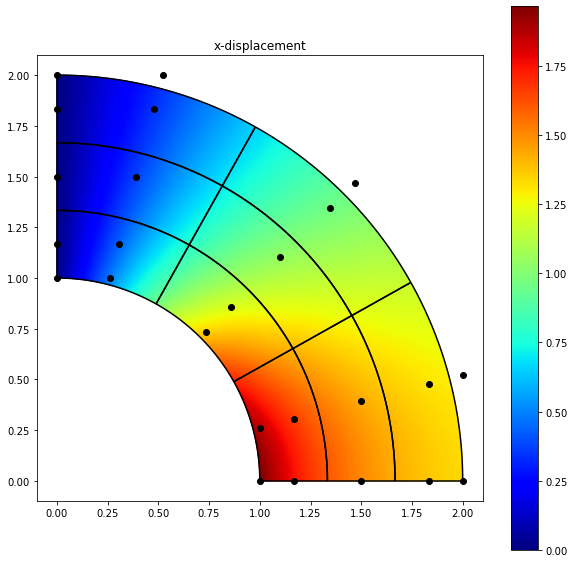

In [18]:
# post process
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('x-displacement')
ax.set_aspect('equal')
plot = plot_nurbs_surface(ax, p0, p1, U0, U1, P, w, d[:,0], res=0.01, cmap='jet', shading='gouraud', rasterized=True)
iso = plot_nurbs_surface_isolines(ax, p0, p1, U0, U1, P, w, res=0.01, color='k')
ax.plot(P[:,0], P[:,1], 'ko')
fig.colorbar(plot)
plt.show()
plt.close(fig)

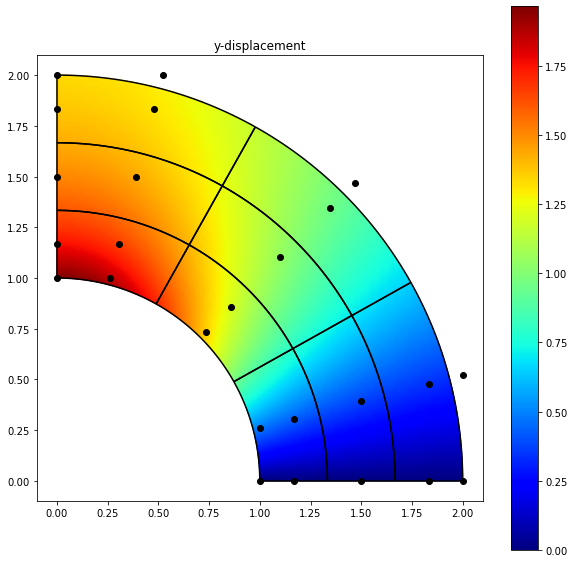

In [19]:
# post process
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('y-displacement')
ax.set_aspect('equal')
plot = plot_nurbs_surface(ax, p0, p1, U0, U1, P, w, d[:,1], res=0.01, cmap='jet', shading='gouraud', rasterized=True)
iso = plot_nurbs_surface_isolines(ax, p0, p1, U0, U1, P, w, res=0.01, color='k')
ax.plot(P[:,0], P[:,1], 'ko')
fig.colorbar(plot)
plt.show()
plt.close(fig)

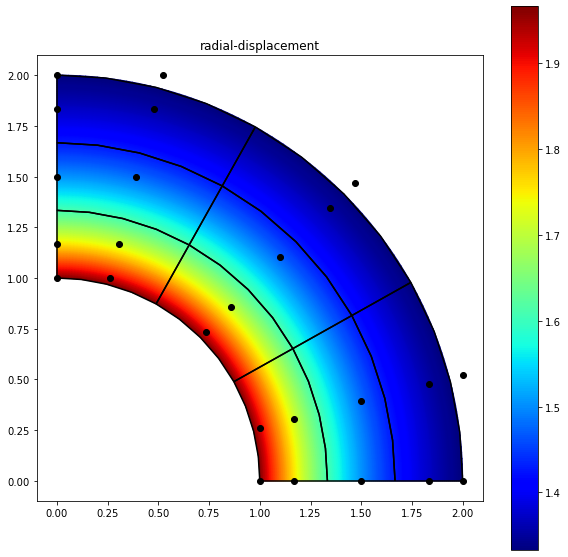

In [20]:
# post process
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title('radial-displacement')
ax.set_aspect('equal')
plot = plot_radial_displacement(ax, element_connectivity, elem_spans, p0, p1, P, w, C, d, res=0.01, cmap='jet', shading='gouraud', rasterized=True)
iso = plot_nurbs_surface_isolines(ax, p0, p1, U0, U1, P, w, res=0.1, color='k')
ax.plot(P[:,0], P[:,1], 'ko')
fig.colorbar(plot)
plt.show()
plt.close(fig)

In [21]:
# compute L2 error
L2_error = compute_L2_error(pressure, ri, ro, E, nu, element_connectivity, elem_spans, p0, p1, P, w, C, d, 4, 4)
print('L2_error = ', L2_error)

L2_error =  1.4745457669600407e-06


In [22]:
# bonus
def make_convergence_plot(ax, ri, ro, pi, E, nu, p0, p1, N0, N1, q0, q1, q):
    n = len(N1)
    h = np.divide(1,N1)
    errors = np.zeros([n])
    for i in range(n):
        # build geometry
        U0, U1, P, w = build_nurbs_quarter_circle(ri, ro, p0, p1, N0[i], N1[i])
        # preprocess
        element_connectivity, elem_spans = build_element_connectivity_and_span_arrays(p0, p1, U0, U1)
        constraints, neumann_edges = build_boundary_condition_array(p0, p1, U0, U1, N0[i], N1[i])
        ID = build_ID_array(p0, p1, U0, U1, constraints)
        C = compute_element_bezier_extraction_operators_2d(p0, p1, U0, U1)
        # integration and assembly
        K = compute_global_stiffness_matrix(ID, element_connectivity, elem_spans, p0, p1, P, w, C, E, nu, q0, q1)
        F = compute_global_force_vector(ID, element_connectivity, neumann_edges, elem_spans, p0, p1, P, w, C, pressure, q)
        # solve linear system
        d = solve(ID, K, F)
        # compute error
        errors[i] = compute_L2_error(pressure, ri, ro, E, nu, element_connectivity, elem_spans, p0, p1, P, w, C, d, 4, 4)
    return ax.plot(h, errors, 'k-o')

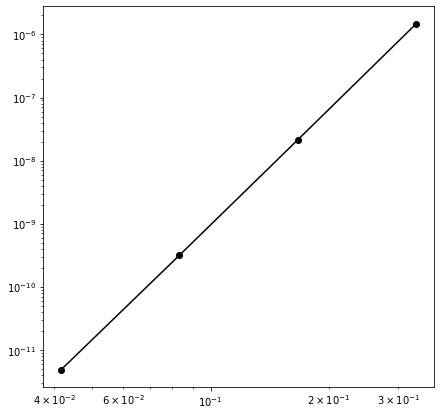

In [23]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
nelems = [3,6,12,24]
make_convergence_plot(ax, ri, ro, pressure, E, nu, p0, p1, nelems, nelems, q0, q1, q)
ax.set_xscale('log')
ax.set_yscale('log')